### Установка

In [1]:
!pip3 install deeplake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.1/430.1 kB 2.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.7 MB/s eta 0:00:00
  Created wheel for deeplake: filename=deeplake-3.2.5-py3-none-any.whl size=525171 sha256=10acc5c3a835d7947ca6809516415e8728e480eb8495b26544274af515b8b06b
  Stored in directory: /Users/tainella/Library/Caches/pip/wheels/b6/bc/8f/a0e7ac310c73c45b3a06404699eae134caf3c1d3dd160b732a

## Создание своего датасета

In [41]:
import os
import numpy as np
from PIL import Image

import deeplake

### Датасет для классификации изображений: FER-2013

Скачать урезанный датасет для демонстрации работы можно на https://wiki.ai-space.ru/display/AIS/DeepLake, файл fer2013.zip

In [24]:
# Найдем class_names и список файлов, которые необходимо загрузить
dataset_folder = './fer2013/train'

# Найти вложенные папки, но отфильтруйте дополнительные файлы,
#такие как DS_Store, которые добавляются на Mac
class_names = [item for item in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, item))]

In [43]:
!ls ./fer2013/train

angry    disgust  fear     happy    neutral  sad      surprise


In [25]:
print(class_names, '\n')

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust'] 



In [33]:
#Создание пустого DeepLake-датасета. В аргументе - путь до папки на компьютере, куда помещается датасет
ds = deeplake.empty('./deeplake_fer')

Для добавления данных создаются тензоры, по которым разносят абстракции: сами данные, разметка, дополнительная информация. Для этого использовать команду 'ds.create_tensor'

htype - тип данных, варианты доступны в документации. Необязателен, но рекомендуется для производительности

sample_compression - расширение медиаданных

In [34]:
#'with ds' ускоряет работу библиотеки, рекомендуется авторами

with ds:
    ds.create_tensor('images', htype = 'image', sample_compression = 'jpeg')
    ds.create_tensor('labels', htype = 'class_label', class_names = class_names)

    # Дополнительная информация по датасету или отдельному тензору
    ds.info.update(description = 'My first Deep Lake dataset')
    ds.images.info.update(camera_type = 'SLR')

In [37]:
#Добавление данных в тензоры

with ds:
    for item in os.listdir(dataset_folder):
        if os.path.isdir(os.path.join(dataset_folder, item)):
            tmp_path = os.path.join(dataset_folder, item)
            for file in os.listdir(tmp_path):
                if "jpg" in file:
                    label_text = item
                    label_num = class_names.index(label_text)

                    ds.append({'images': deeplake.read(os.path.join(tmp_path, file)), 'labels': np.uint32(label_num)})

Проверка записи

In [39]:
ds.summary()

Dataset(path='./deeplake_fer', tensors=['images', 'labels'])

 tensor      htype        shape       dtype  compression
 -------    -------      -------     -------  ------- 
 images      image     (21, 48, 48)   uint8    jpeg   
 labels   class_label    (21, 1)     uint32    None   


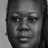

In [42]:
Image.fromarray(ds.images[4].numpy())

### Датасет временного ряда

Скачать урезанный датасет для демонстрации работы можно на https://wiki.ai-space.ru/display/AIS/DeepLake, файл sensor_data.zip

Структура датасета:

    |_subjects_into.csv
    |_motion_data
        |_walk
            |_sub_1.csv
            |_sub_2.csv
            ...
            ...
        |_jog
            |_sub_1.csv
            |_sub_2.csv
            ...
            ...

In [57]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [51]:
ds = deeplake.empty('./sensor_data_deeplake')

dataset_path= './sensor_data'
subjects_info = pd.read_csv(os.path.join(dataset_path, 'subjects_info.csv'))

fns_series = []
for dirpath, dirnames, filenames in os.walk(os.path.join(dataset_path, 'motion_data')):
    for filename in filenames:
        fns_series.append(os.path.join(dirpath, filename))

In [52]:
with ds:
    #Инфо по датасету
    ds.info.update(source = 'https://www.kaggle.com/malekzadeh/motionsense-dataset', 
                   notes = 'This is a small subset of the data in the source link')

    #Создайте тензоры. Настройка chunk_compression необязательна, и по умолчанию она равна None
    ds.create_tensor('acceleration_x', chunk_compression = 'lz4') 
    ds.create_tensor('acceleration_y', chunk_compression = 'lz4')
    
    #Сохраним частоту дискретизации в виде метаданных тензора. Или можно создать тензор "время".
    ds.acceleration_x.info.update(sampling_rate_s = 0.1)
    ds.acceleration_y.info.update(sampling_rate_s = 0.1)
    
    # Кодируем активность как текст
    ds.create_tensor('activity', htype = 'text')
    
    # Или "активность" в виде числовых меток и преобразуем в текст с помощью class_names
    # ds.create_tensor('activity', htype = 'class_label', class_names = ['xyz'])
    
    ds.create_group('subjects_info')
    ds.subjects_info.create_tensor('age')
    ds.subjects_info.create_tensor('weight')
    ds.subjects_info.create_tensor('height')
    
    # Сохраним единицы веса в виде метаданных тензора
    ds.subjects_info.weight.info.update(units = 'kg')
    ds.subjects_info.height.info.update(units = 'cm')

In [55]:
with ds:
    for fn in tqdm(fns_series):
        
        # Прочитаем данные
        df_data = pd.read_csv(fn)
        
        # Достаним тип активности
        activity = os.path.basename(os.path.dirname(fn))
        
        subject_code = int(os.path.splitext(os.path.basename(fn))[0].split('_')[1])
        subject_info = subjects_info[subjects_info['code']==subject_code]
        
        # Добавим в тензоры
        ds.activity.append(activity)
        ds.subjects_info.age.append(subject_info['age'].values)
        ds.subjects_info.weight.append(subject_info['weight'].values)
        ds.subjects_info.height.append(subject_info['height'].values)
                
        ds.acceleration_x.append(df_data['userAcceleration.x'].values)
        ds.acceleration_y.append(df_data['userAcceleration.y'].values)

100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 264.54it/s]


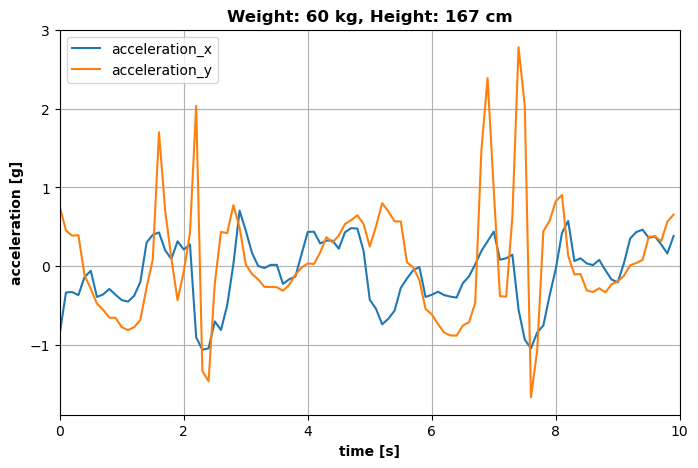

In [58]:
s_ind = 0
t_ind = 100

#Построим график ускорения x
x_data = ds.acceleration_x[s_ind].numpy()[:t_ind]
sampling_rate_x = ds.acceleration_x.info.sampling_rate_s

plt.plot(np.arange(0, x_data.size)*sampling_rate_x, x_data, label='acceleration_x')

#Построим график ускорения у
y_data = ds.acceleration_y[s_ind].numpy()[:t_ind]
sampling_rate_y = ds.acceleration_y.info.sampling_rate_s

plt.plot(np.arange(0, y_data.size)*sampling_rate_y, y_data, label='acceleration_y')

plt.legend()
plt.xlabel('time [s]', fontweight = 'bold')
plt.ylabel('acceleration [g]', fontweight = 'bold')
plt.title('Weight: {} {}, Height: {} {}'.format(ds.subjects_info.weight[s_ind].numpy()[0],
                                               ds.subjects_info.weight.info.units,
                                               ds.subjects_info.height[s_ind].numpy()[0],
                                               ds.subjects_info.height.info.units),
         fontweight = 'bold')

plt.xlim([0, 10])
plt.grid()
plt.gcf().set_size_inches(8, 5)
plt.show()

In [59]:
ds.summary()

Dataset(path='./sensor_data_deeplake', tensors=['acceleration_x', 'acceleration_y', 'activity', 'subjects_info/age', 'subjects_info/weight', 'subjects_info/height'])

        tensor          htype       shape        dtype  compression
       -------         -------     -------      -------  ------- 
    acceleration_x     generic  (48, 765:6305)   None     None   
    acceleration_y     generic  (48, 765:6305)   None     None   
       activity         text       (48, 1)        str     None   
  subjects_info/age    generic     (48, 1)       int64    None   
 subjects_info/weight  generic     (48, 1)       int64    None   
 subjects_info/height  generic     (48, 1)       int64    None   


## Загрузка датасета из папки

In [61]:
ds = deeplake.load('./deeplake_fer')

./deeplake_fer loaded successfully.


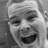

In [63]:
Image.fromarray(ds.images[1].numpy())

In [64]:
#Обновление данных

ds.images[1] = ds.images[3] #deeplake.read('https://i.postimg.cc/Yq2SNz9J/photo-1534567110243-8875d64ca8ff.jpg')
ds.labels[1] = 'giraffe'

'giraffe' added to labels.info.class_names at index 7


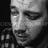

In [65]:
Image.fromarray(ds.images[1].numpy())